In [1]:
import os 
import h5py
import numpy as np 
import corner as DFM 
# -- galpopfm --
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']

In [3]:
# read in SDSS measurements 
fsdss = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.valueadd.hdf5') 
sdss = h5py.File(fsdss, 'r') 

mr_complete = (sdss['mr_tinker'][...] < -20.) 
F_mag_sdss = sdss['ABSMAG'][...][:,0][mr_complete]
N_mag_sdss = sdss['ABSMAG'][...][:,1][mr_complete]
R_mag_sdss = sdss['mr_tinker'][...][mr_complete] #sdss['ABSMAG'][...][:,4]
FUV_NUV_sdss = F_mag_sdss - N_mag_sdss

Haflux_sdss = sdss['HAFLUX'][...][mr_complete]
Hbflux_sdss = sdss['HBFLUX'][...][mr_complete]
balmer_ratio_sdss = Haflux_sdss/Hbflux_sdss 

# read in SDSS LF 
fphi = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.phi_Mr.dat') 
mr_low, mr_high, phi_sdss, phi_sdss_err = np.loadtxt(fphi, unpack=True, usecols=[0,1,2,3]) 

read in SIMBA and TNG SEDs

In [4]:
# read in SIMBA
_sim_sed = dustInfer._read_sed('simba') 
wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
downsample = np.zeros(len(_sim_sed['logmstar'])).astype(bool)
downsample[::10] = True
f_downsample = 0.1

cens = _sim_sed['censat'].astype(bool) & (_sim_sed['logmstar'] > 9.4) & downsample

sim_sed = {} 
sim_sed['sim']          = 'simba'
sim_sed['logmstar']     = _sim_sed['logmstar'][cens].copy()
sim_sed['logsfr.100']   = _sim_sed['logsfr.100'][cens].copy() 
sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
sim_sed['sed']    = _sim_sed['sed_neb'][cens,:][:,wlim].copy() 
sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cens,:][:,wlim].copy() 
sim_sed['sed_onlyneb']    = _sim_sed['sed_onlyneb'][cens,:][:,wlim].copy() 


# read in TNG
_tng_sed = dustInfer._read_sed('tng') 
wlim = (_tng_sed['wave'] > 1e3) & (_tng_sed['wave'] < 8e3) 
downsample = np.zeros(len(_tng_sed['logmstar'])).astype(bool)
downsample[::10] = True

cens = _tng_sed['censat'].astype(bool) & (_tng_sed['logmstar'] > 9.4) & downsample

tng_sed = {} 
tng_sed['sim']          = 'tng'
tng_sed['logmstar']     = _tng_sed['logmstar'][cens].copy()
tng_sed['logsfr.100']   = _tng_sed['logsfr.100'][cens].copy() 
tng_sed['wave']         = _tng_sed['wave'][wlim].copy()
tng_sed['sed']    = _tng_sed['sed_neb'][cens,:][:,wlim].copy() 
tng_sed['sed_noneb']    = _tng_sed['sed_noneb'][cens,:][:,wlim].copy() 
tng_sed['sed_onlyneb']    = _tng_sed['sed_onlyneb'][cens,:][:,wlim].copy() 

In [5]:
def sim_observables_AV(A_V, sim='simba'): 
    '''
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()

        
    T_lam = 10.0**(-0.4 * A_V * dustFM.calzetti_absorption(sed['wave']))
    sed_dusty = sed['sed'] * T_lam
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    FUV_NUV = F_mag - N_mag 
    
    # balmer measurements 
    Ha_dust, Hb_dust = measureObs.L_em(['halpha', 'hbeta'], sim_sed['wave'], sed_dusty) 
    balmer_ratio = Ha_dust/Hb_dust
    
    # get luminosity function 
    mr_mid, phi_sim = measureObs.LumFunc(R_mag, name=sim_sed['sim'], mr_bin=None)
    phi_sim /= f_downsample # in case you downsample 
    
    return R_mag, FUV_NUV, balmer_ratio, mr_mid, phi_sim

In [6]:
HaHb_I = 2.86 # intrinsic balmer ratio 

Try directly changing A_V

(-20.0, -24.0)

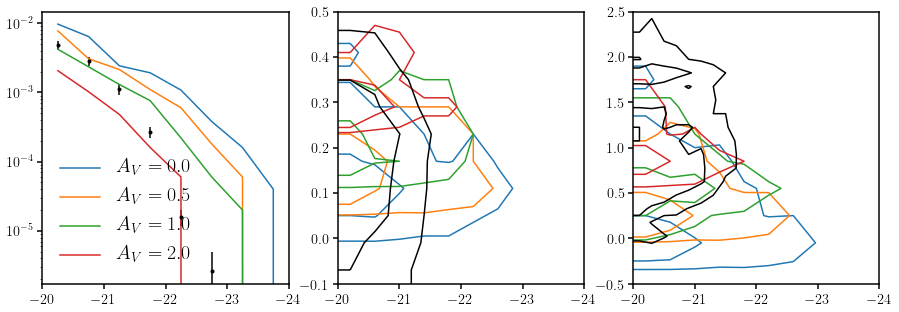

In [8]:
avs = [0., 0.5, 1., 2.]
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
for i, av in enumerate(avs):
    _, _, _, mr_mid, phi_sim = sim_observables_AV(av, sim='simba')
    sub.plot(mr_mid, phi_sim, c='C%i' % i, label=r'$A_V=%.1f$' % av)
sub.errorbar(mr_mid, phi_sdss, yerr=phi_sdss_err, fmt='.k')
sub.legend(loc='lower left', fontsize=20)
sub.set_xlim(-20., -24.)
sub.set_yscale('log')

sub = fig.add_subplot(132)
for i, av in enumerate(avs):
    R_mag, _, balmer_ratio, _, _ = sim_observables_AV(av, sim='simba')
    DFM.hist2d(R_mag, np.log10(balmer_ratio/HaHb_I), color='C%i' % i,
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
DFM.hist2d(R_mag_sdss, np.log10(balmer_ratio_sdss/HaHb_I), color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub)     
sub.set_xlim(-20., -24.)

sub = fig.add_subplot(133)
for i, av in enumerate(avs):
    R_mag, FUV_NUV, _, _, _ = sim_observables_AV(av, sim='simba')
    DFM.hist2d(R_mag, FUV_NUV, color='C%i' % i, 
            levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], bins=10,
            plot_datapoints=False, fill_contours=False, plot_density=False, 
            ax=sub) 
DFM.hist2d(R_mag_sdss, FUV_NUV_sdss, color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], 
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
sub.set_xlim(-20., -24.)


Now lets try changing tau_V

In [9]:
def sim_observables_tauV(tauV, sim='simba'): 
    '''
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()
    #m_tau c_tau m_delta c_delta m_E c_E fneb


    sed_dusty = dustFM.Attenuate(
        np.array([0., tauV, 1.]), 
        sed['wave'], 
        sed['sed_noneb'], 
        sed['sed_onlyneb'], 
        sed['logmstar'],
        sed['logsfr.100'],
        dem='slab_calzetti') 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    FUV_NUV = F_mag - N_mag 
    
    # balmer measurements 
    Ha_dust, Hb_dust = measureObs.L_em(['halpha', 'hbeta'], sim_sed['wave'], sed_dusty) 
    balmer_ratio = Ha_dust/Hb_dust
    
    # get luminosity function 
    mr_mid, phi_sim = measureObs.LumFunc(R_mag, name=sim_sed['sim'], mr_bin=None)
    phi_sim /= f_downsample # in case you downsample 
    
    return R_mag, FUV_NUV, balmer_ratio, mr_mid, phi_sim

(-20.0, -24.0)

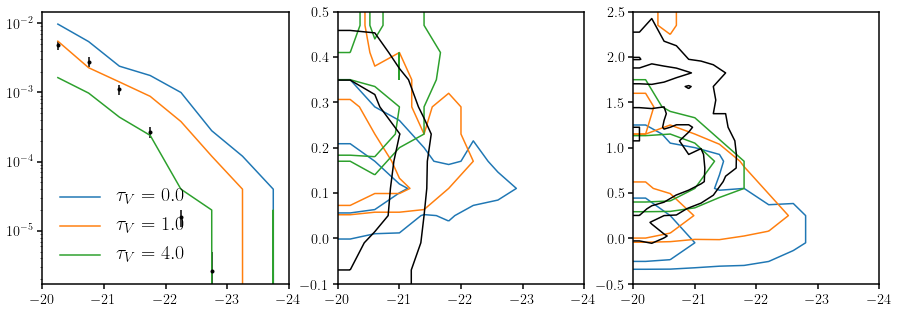

In [10]:
tauvs = [0.0, 1., 4.]
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
for i, tauv in enumerate(tauvs):
    _, _, _, mr_mid, phi_sim = sim_observables_tauV(tauv, sim='simba')
    sub.plot(mr_mid, phi_sim, c='C%i' % i, label=r'$\tau_V=%.1f$' % tauv)
sub.errorbar(mr_mid, phi_sdss, yerr=phi_sdss_err, fmt='.k')
sub.legend(loc='lower left', fontsize=20)
sub.set_xlim(-20., -24.)
sub.set_yscale('log')

sub = fig.add_subplot(132)
for i, tauv in enumerate(tauvs):
    R_mag, _, balmer_ratio, _, _ = sim_observables_tauV(tauv, sim='simba')
    DFM.hist2d(R_mag, np.log10(balmer_ratio/HaHb_I), color='C%i' % i,
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
DFM.hist2d(R_mag_sdss, np.log10(balmer_ratio_sdss/HaHb_I), color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub)     
sub.set_xlim(-20., -24.)

sub = fig.add_subplot(133)
for i, tauv in enumerate(tauvs):
    R_mag, FUV_NUV, _, _, _= sim_observables_tauV(tauv, sim='simba')
    DFM.hist2d(R_mag, FUV_NUV, color='C%i' % i, 
            levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], bins=10,
            plot_datapoints=False, fill_contours=False, plot_density=False, 
            ax=sub) 
DFM.hist2d(R_mag_sdss, FUV_NUV_sdss, color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], 
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
sub.set_xlim(-20., -24.)


In [11]:
def sim_observables_tauV_delta(tauV, delta, sim='simba'): 
    '''
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()
        
    #m_tau c_tau m_delta c_delta m_E c_E fneb
    sed_dusty = dustFM.Attenuate(
        np.array([0., tauV, 0., delta, 0., 0., 1.]), 
        sed['wave'], 
        sed['sed_noneb'], 
        sed['sed_onlyneb'], 
        sed['logmstar'],
        sed['logsfr.100'],
        dem='slab_noll_m') 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    FUV_NUV = F_mag - N_mag 
    
    # balmer measurements 
    Ha_dust, Hb_dust = measureObs.L_em(['halpha', 'hbeta'], sim_sed['wave'], sed_dusty) 
    balmer_ratio = Ha_dust/Hb_dust
    
    # get luminosity function 
    mr_mid, phi_sim = measureObs.LumFunc(R_mag, name=sim_sed['sim'], mr_bin=None)
    phi_sim /= f_downsample # in case you downsample 
    
    return R_mag, FUV_NUV, balmer_ratio, mr_mid, phi_sim

(-20.0, -24.0)

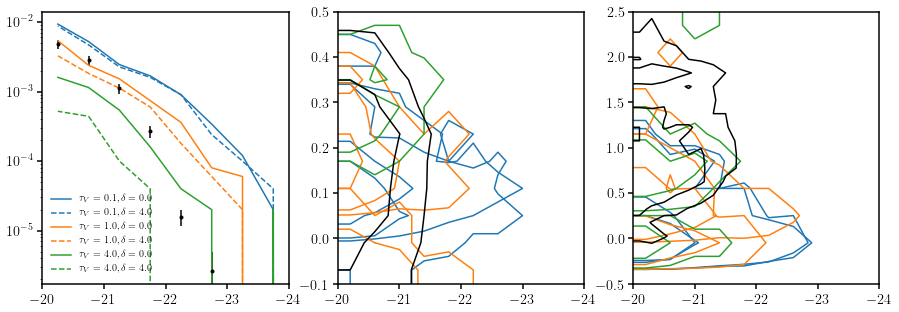

In [15]:
tauvs = [0.1, 1., 4.]
deltas = [0., 4.]
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas): 
        _, _, _, mr_mid, phi_sim = sim_observables_tauV_delta(tauv, delta, sim='simba')
        sub.plot(mr_mid, phi_sim, c='C%i' %i, ls=['-', '--', '-.'][ii],
                 label=r'$\tau_V=%.1f, \delta=%.1f$' % (tauv, delta))
sub.errorbar(mr_mid, phi_sdss, yerr=phi_sdss_err, fmt='.k')
sub.legend(loc='lower left', fontsize=10)
sub.set_xlim(-20., -24.)
sub.set_yscale('log')

sub = fig.add_subplot(132)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas):         
        R_mag, _, balmer_ratio, _, _ = sim_observables_tauV_delta(tauv, delta, sim='simba')
        DFM.hist2d(R_mag, np.log10(balmer_ratio/HaHb_I), color='C%i' % i, linestyle=['-', '--', '-.'][ii],
            levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
            plot_datapoints=False, fill_contours=False, plot_density=False, 
            ax=sub) 
DFM.hist2d(R_mag_sdss, np.log10(balmer_ratio_sdss/HaHb_I), color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub)     
sub.set_xlim(-20., -24.)

sub = fig.add_subplot(133)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas):         
        R_mag, FUV_NUV, _, _, _= sim_observables_tauV_delta(tauv, delta, sim='simba')
        DFM.hist2d(R_mag, FUV_NUV, color='C%i' % i, 
                levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], bins=10,
                plot_datapoints=False, fill_contours=False, plot_density=False, 
                ax=sub) 
DFM.hist2d(R_mag_sdss, FUV_NUV_sdss, color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], 
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
sub.set_xlim(-20., -24.)

(-20.0, -24.0)

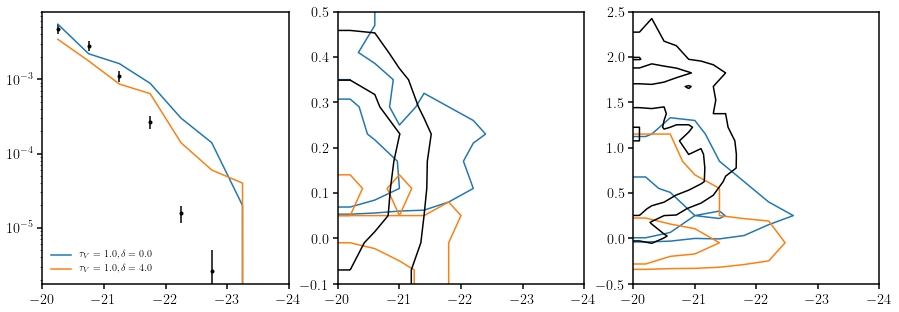

In [17]:
tauvs = [1.]
deltas = [0., 4.]
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas): 
        _, _, _, mr_mid, phi_sim = sim_observables_tauV_delta(tauv, delta, sim='simba')
        sub.plot(mr_mid, phi_sim, c='C%i' % ii,
                 label=r'$\tau_V=%.1f, \delta=%.1f$' % (tauv, delta))
sub.errorbar(mr_mid, phi_sdss, yerr=phi_sdss_err, fmt='.k')
sub.legend(loc='lower left', fontsize=10)
sub.set_xlim(-20., -24.)
sub.set_yscale('log')

sub = fig.add_subplot(132)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas):         
        R_mag, _, balmer_ratio, _, _ = sim_observables_tauV_delta(tauv, delta, sim='simba')
        DFM.hist2d(R_mag, np.log10(balmer_ratio/HaHb_I), color='C%i' % ii, 
            levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
            plot_datapoints=False, fill_contours=False, plot_density=False, 
            ax=sub) 
DFM.hist2d(R_mag_sdss, np.log10(balmer_ratio_sdss/HaHb_I), color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub)     
sub.set_xlim(-20., -24.)

sub = fig.add_subplot(133)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas):         
        R_mag, FUV_NUV, _, _, _= sim_observables_tauV_delta(tauv, delta, sim='simba')
        DFM.hist2d(R_mag, FUV_NUV, color='C%i' % ii, 
                levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], bins=10,
                plot_datapoints=False, fill_contours=False, plot_density=False, 
                ax=sub) 
DFM.hist2d(R_mag_sdss, FUV_NUV_sdss, color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], 
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
sub.set_xlim(-20., -24.)

In [18]:
def sim_observables_tauV_delta_fneb(tauV, delta, fneb, sim='simba'): 
    '''
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()
        
    #m_tau c_tau m_delta c_delta m_E c_E fneb
    sed_dusty = dustFM.Attenuate(
        np.array([0., tauV, 0., delta, 0., 0., fneb]), 
        sed['wave'], 
        sed['sed_noneb'], 
        sed['sed_onlyneb'], 
        sed['logmstar'],
        sed['logsfr.100'],
        dem='slab_noll_m') 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    FUV_NUV = F_mag - N_mag 
    
    # balmer measurements 
    Ha_dust, Hb_dust = measureObs.L_em(['halpha', 'hbeta'], sim_sed['wave'], sed_dusty) 
    balmer_ratio = Ha_dust/Hb_dust
    
    # get luminosity function 
    mr_mid, phi_sim = measureObs.LumFunc(R_mag, name=sim_sed['sim'], mr_bin=None)
    phi_sim /= f_downsample # in case you downsample 
    
    return R_mag, FUV_NUV, balmer_ratio, mr_mid, phi_sim

(-20.0, -24.0)

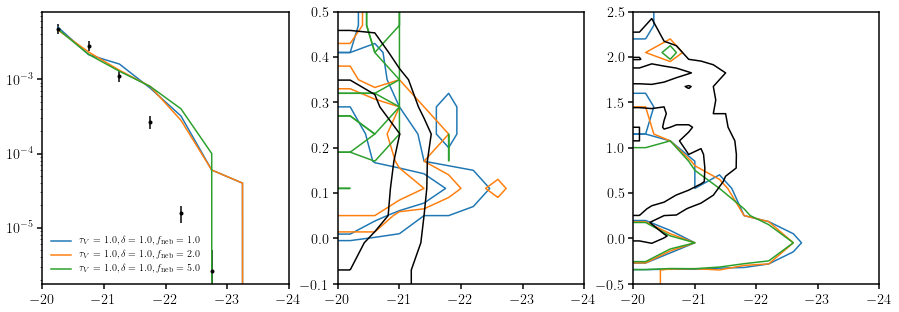

In [21]:
tauvs = [1.]
deltas = [1.]
fnebs = [1., 2., 5.]
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas): 
        for iii, fneb in enumerate(fnebs): 
            _, _, _, mr_mid, phi_sim = sim_observables_tauV_delta_fneb(tauv, delta, fneb, sim='simba')
            sub.plot(mr_mid, phi_sim, c='C%i' % iii,
                     label=r'$\tau_V=%.1f, \delta=%.1f, f_{\rm neb} = %.1f$' % (tauv, delta, fneb))
sub.errorbar(mr_mid, phi_sdss, yerr=phi_sdss_err, fmt='.k')
sub.legend(loc='lower left', fontsize=10)
sub.set_xlim(-20., -24.)
sub.set_yscale('log')

sub = fig.add_subplot(132)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas):     
        for iii, fneb in enumerate(fnebs): 
            R_mag, _, balmer_ratio, _, _ = sim_observables_tauV_delta_fneb(tauv, delta, fneb, sim='simba')
            DFM.hist2d(R_mag, np.log10(balmer_ratio/HaHb_I), color='C%i' % iii, 
                levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
                plot_datapoints=False, fill_contours=False, plot_density=False, 
                ax=sub) 
DFM.hist2d(R_mag_sdss, np.log10(balmer_ratio_sdss/HaHb_I), color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.1, 0.5]], bins=10,
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub)     
sub.set_xlim(-20., -24.)

sub = fig.add_subplot(133)
for i, tauv in enumerate(tauvs):
    for ii, delta in enumerate(deltas):   
        for iii, fneb in enumerate(fnebs): 
            R_mag, FUV_NUV, _, _, _= sim_observables_tauV_delta_fneb(tauv, delta, fneb, sim='simba')
            DFM.hist2d(R_mag, FUV_NUV, color='C%i' % iii, 
                    levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], bins=10,
                    plot_datapoints=False, fill_contours=False, plot_density=False, 
                    ax=sub) 
DFM.hist2d(R_mag_sdss, FUV_NUV_sdss, color='k', 
        levels=[0.68, 0.95], range=[[-20, -24], [-0.5, 2.5]], 
        plot_datapoints=False, fill_contours=False, plot_density=False, 
        ax=sub) 
sub.set_xlim(-20., -24.)